
# Time Series Forecasting using Prophet

In [1]:
%matplotlib inline

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np
import datetime

# Data visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams
import scipy

# Set font scale and style
plt.rcParams.update({'font.size': 18})

# Facebook prophet
from prophet import Prophet

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
# import custom class
%run -i '../src/helper/ts.py'

In [3]:
# Instantiate the class
fxn = TimeSeriesForecasting()

# Load  data

In [4]:
ts = pd.read_csv('../data/collision_ts_month.csv') # load data
ts.date = pd.to_datetime(ts['date'])  # convert to datetime
ts.index = ts.date # make date the dataframe index
ts = ts.drop(['date', 'summer_ind'], axis =1)

print("Data size:", ts.shape)
ts.head()

Data size: (228, 11)


,fatality_rate,p_isev_Fatality,p_isev_Injury,p_isev_No Injury,conf_ind_head-on,conf_ind_not-head-on,c_vehs,c_hour,p_age,year,month
date,,,,,,,,,,,
1999-01-01,0.012911,163.0,164.0,89.0,152.0,281.0,2.042258,13.511338,35.239035,1999,1
1999-02-01,0.018163,196.0,176.0,97.0,139.0,343.0,2.006859,13.499924,35.102478,1999,2
1999-03-01,0.020982,219.0,250.0,122.0,149.0,469.0,2.028966,13.507759,34.717830,1999,3
1999-04-01,0.015418,190.0,154.0,83.0,82.0,356.0,2.041576,13.890340,34.662779,1999,4
1999-05-01,0.017953,266.0,248.0,99.0,114.0,523.0,2.037239,13.851641,34.548825,1999,5


##  Create a test  set
We must split the dataset into training and test (out-of-sample) set. We have chosen the test set as the last year's observations (i.e. 2017).

In [5]:
train_start, train_end = '1999-01-01','2014-12-01'
test_start, test_end = '2014-01-01', '2017-12-01'

X_train = ts.drop('fatality_rate', axis =1)[train_start: train_end]
y_train = ts['fatality_rate'][train_start: train_end]

X_test = ts.drop('fatality_rate', axis =1)[test_start: test_end]
y_test = ts['fatality_rate'][test_start: test_end]

## Normalization

In [6]:
# Standardization
scaler_y = StandardScaler() 
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)) 

# Normalization 
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Pandas dataframe
y_train_df = pd.DataFrame(y_train_scaled, columns=['y'], index = y_train.index)
X_train_df = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_df = pd.DataFrame(X_test_scaled, columns = X_test.columns)
X_train_df.insert(0,'y', y_train_df.y.values)
X_train_df.insert(0,'ds', y_train.index)
X_test_df.insert(0,'ds', y_test.index)

## Prophet 

In [7]:
# Train Prophet
model = Prophet(changepoint_prior_scale=0.01, seasonality_mode='additive',
            yearly_seasonality=10, 
            weekly_seasonality=True, 
            daily_seasonality=False)
model.add_seasonality(name='monthly', period=30, fourier_order=5)

for col in X_train.columns: 
    model.add_regressor(col, mode='additive')
model.fit(X_train_df)

# Make forecast
forecast = model.predict(X_test_df)
yhat = forecast['yhat'].values
yhat = scaler_y.inverse_transform(yhat.reshape(-1,1)).flatten()

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


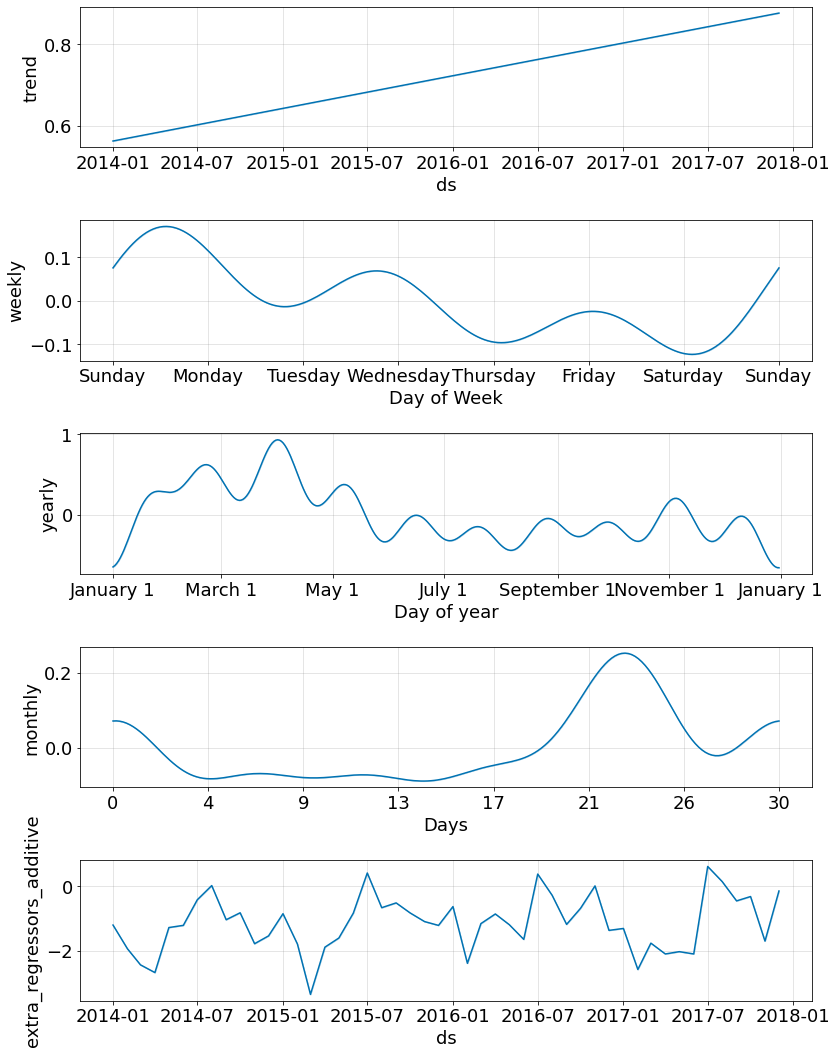

In [8]:
fig = model.plot_components(forecast, figsize = (12,15))

## Performance measures (error metrics)

In [9]:
fxn.error_metrics(y_test, yhat)

{'MAE = 0.001', 'MAPE = 8.474', 'RMSE = 0.001', 'R^2 = 0.691', 'WMAPE = 7.339'}

In [10]:
yhat[yhat<0] = 0

ylow = forecast['yhat_lower'].values
ylow = scaler_y.inverse_transform(ylow.reshape(-1,1)).flatten()
ylow[ylow<0] = 0

yhigh = forecast['yhat_upper'].values
yhigh = scaler_y.inverse_transform(yhigh.reshape(-1,1)).flatten()
yhigh[yhigh<0] = 0

results = pd.DataFrame()
results['yhat'] = yhat
results['ylow'] = ylow
results['yhigh'] = yhigh
results.index = y_test.index

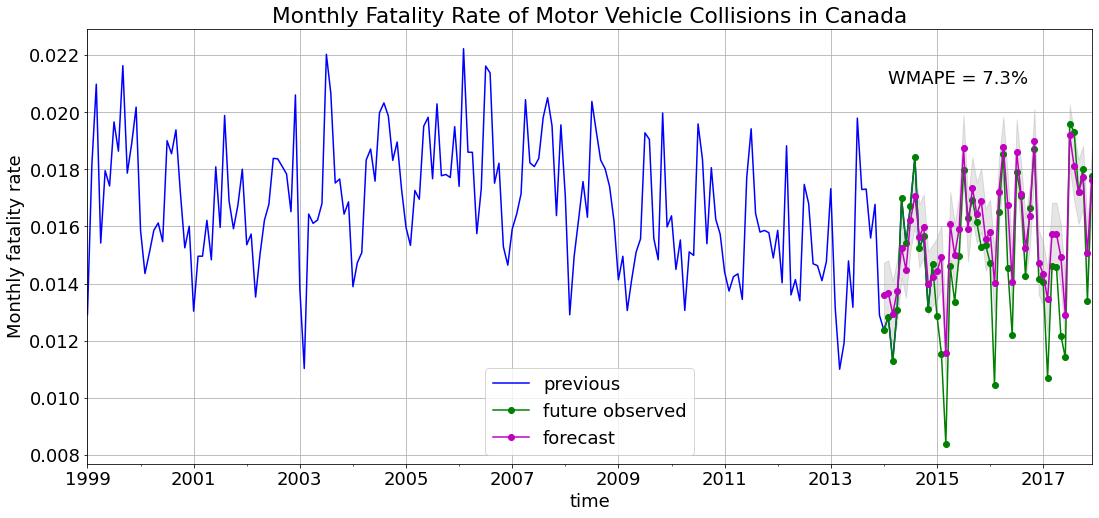

In [13]:
plt.figure(figsize = (18,8))

y_train.plot(label = 'previous', color = 'b')
y_test.plot(label = 'future observed', marker = 'o', color = 'g')
results['yhat'].plot(label = 'forecast', marker = 'o', color = 'm')

plt.fill_between(results.index, results['ylow'], results['yhigh'], color='k', alpha=0.1)
plt.xlabel('time')
plt.text('2014-02-01', 0.021, "WMAPE = 7.3%")
plt.grid(True)
plt.ylabel('Monthly fatality rate')
plt.title('Monthly Fatality Rate of Motor Vehicle Collisions in Canada')
plt.legend()
plt.savefig('../images/propt.png')
plt.show()

## Test set error

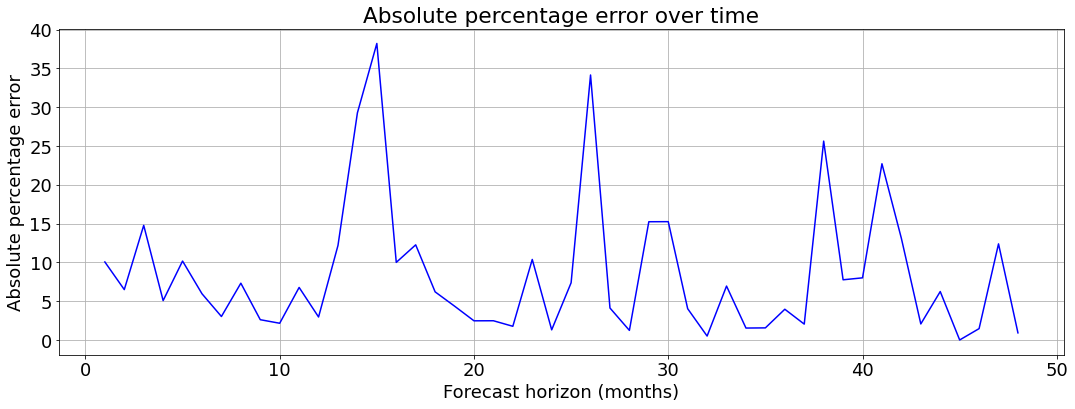

In [12]:
plt.figure(figsize = (18,6))
abs_err = 100*np.abs((y_test.values-yhat)/(y_test.values))

plt.plot(np.arange(1, len(abs_err)+1), abs_err, color = 'b')
plt.grid(True)
plt.xlabel('Forecast horizon (months)')
plt.ylabel('Absolute percentage error')
plt.title('Absolute percentage error over time')
plt.show()